<a href="https://colab.research.google.com/github/A-H-Sumon/Deep-Learning/blob/main/WithOutLBPFusionNet_PrimaryDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from joblib import Parallel, delayed
import multiprocessing

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage.filters import gabor
from joblib import Parallel, delayed
import multiprocessing
from termcolor import colored

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/drive/My Drive/dataset.csv", dtype=str)  # Ensure paths are read as strings

# Define features and labels
X = df["image_path"]  # Image paths
y = df["label"].astype(int)  # Labels as integers

# Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Create DataFrames
train_df = pd.DataFrame({"image_path": X_train, "label": y_train})
test_df = pd.DataFrame({"image_path": X_test, "label": y_test})




In [4]:
print(df['label'].unique())  # Check unique labels in the dataset
print(df['label'].nunique())  # Check the number of unique classes


['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
10


In [5]:
print(f"Total training images: {len(train_df)}")
print(f"Total testing images: {len(test_df)}")

Total training images: 1672
Total testing images: 418


In [6]:
import cv2
import numpy as np
import cv2.ximgproc as xip

def preprocess_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.zeros((28, 28))  # Placeholder for missing images

    # Apply Otsu's Thresholding
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Resize image to 28x28
    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA) / 255.0

    return img


In [7]:
# ======================== Load & Preprocess Images ========================
train_images = np.array([preprocess_image(fp) for fp in train_df['image_path'].values])

In [8]:
import cv2
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

def elastic_transform(image, alpha, sigma):
    """Applies elastic deformation to the image."""
    random_state = np.random.RandomState(None)

    shape = image.shape
    dx = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (5, 5), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (5, 5), sigma) * alpha

    # Ensure the displacement maps are float32
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    x_new = (x + dx).astype(np.float32)
    y_new = (y + dy).astype(np.float32)

    # Apply remap with correct dtype
    distorted = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    return distorted

def augment_image(img):
    rows, cols = img.shape

    # Random Rotation
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))

    # Random Shifting
    tx = random.uniform(-2, 2)
    ty = random.uniform(-2, 2)
    M_shift = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted = cv2.warpAffine(rotated, M_shift, (cols, rows))

    return shifted

def augment_dataset(train_images):
    """Applies augmentation to a dataset using parallel processing."""
    num_cores = multiprocessing.cpu_count()
    augmented_images = Parallel(n_jobs=num_cores)(
        delayed(augment_image)(img) for img in train_images
    )
    return np.array(augmented_images)

# Apply augmentation to dataset
augmented_images = augment_dataset(train_images)




In [9]:
cores = multiprocessing.cpu_count()
print(cores)

2


In [10]:


!pip install mahotas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.5 MB/s eta 0:00:00


In [11]:
from joblib import Parallel, delayed
import numpy as np
import multiprocessing
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from mahotas.features import zernike_moments

# Feature Extraction
def extract_features_single(img):
     # Extract HOG features
    hog_features = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), feature_vector=True)

    # # Extract Gabor features
    gabor_response_real, gabor_response_imag = gabor(img, frequency=0.6)
    gabor_features = np.mean(gabor_response_real) + np.mean(gabor_response_imag)

    # Extract LBP features
    # lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
    # lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    # lbp_hist = lbp_hist.astype("float")
    # lbp_hist /= lbp_hist.sum()  # Normalize LBP histogram

    return np.hstack([hog_features, gabor_features])

def extract_features(images):
    num_cores = multiprocessing.cpu_count()
    features = Parallel(n_jobs=num_cores)(delayed(extract_features_single)(img) for img in images)
    return np.array(features)

# Apply feature extraction
augmented_features = extract_features(augmented_images)



In [12]:
# ======================== Data Preparation ========================
X_train_preprocessed = np.array([preprocess_image(fp) for fp in train_df['image_path']])
X_test_preprocessed = np.array([preprocess_image(fp) for fp in test_df['image_path']])

In [13]:
# Apply augmentation
X_train_augmented = augment_dataset(X_train_preprocessed)




In [14]:
# Extract features from augmented images
X_train_features = extract_features(X_train_augmented)
X_test_features = extract_features(X_test_preprocessed)  # No augmentation for test set

In [15]:
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df['label'])
y_test = encoder.fit_transform(test_df['label'])

In [16]:
!pip install optuna



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.0 MB/s eta 0:00:00


In [17]:
import cv2
import numpy as np
from glob import glob

def load_images(image_paths):
    data = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (64, 64))  # Resize to a fixed size
        img = img.flatten()  # Convert to 1D array
        data.append(img)
    return np.array(data)

# Assuming X_train originally contains image file paths
X_train = load_images(X_train)


In [18]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    """Objective function for optimizing KNN hyperparameters."""

    # Hyperparameters to optimize
    k = trial.suggest_int('n_neighbors', 3, 15)  # Number of neighbors
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    # Initialize KNN classifier
    knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)

    # Perform cross-validation to get accuracy
    score = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score  # Return the mean cross-validation accuracy

In [19]:
study_knn = optuna.create_study(direction='maximize')  # Maximize accuracy
study_knn.optimize(objective, n_trials=50)  # Run 50 trials

# Get the best parameters
best_knn_params = study_knn.best_params
print("Best KNN hyperparameters:", best_knn_params)

[I 2025-07-16 06:36:57,886] A new study created in memory with name: no-name-89d45471-cf65-4557-abe4-e4f65d44c620
[I 2025-07-16 06:36:59,177] Trial 0 finished with value: 0.7924604522298687 and parameters: {'n_neighbors': 7, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 0 with value: 0.7924604522298687.
[I 2025-07-16 06:37:00,980] Trial 1 finished with value: 0.7781160067923854 and parameters: {'n_neighbors': 7, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.7924604522298687.
[I 2025-07-16 06:37:03,649] Trial 2 finished with value: 0.7852783984270266 and parameters: {'n_neighbors': 12, 'metric': 'minkowski', 'weights': 'distance'}. Best is trial 0 with value: 0.7924604522298687.
[I 2025-07-16 06:37:06,611] Trial 3 finished with value: 0.7864831530967915 and parameters: {'n_neighbors': 10, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 0 with value: 0.7924604522298687.
[I 2025-07-16 06:37:08,823] Trial 4 finished with value: 0.77

Best KNN hyperparameters: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'distance'}


In [20]:
# Extract best values
best_k = best_knn_params['n_neighbors']
best_metric = best_knn_params['metric']
best_weights = best_knn_params['weights']

def knn(X_train, y_train, X_test, k=best_k, metric=best_metric, weights=best_weights):
    """Optimized KNN model."""

    # Convert labels to NumPy array (avoid indexing issues)
    y_train = np.array(y_train)

    # Fit KNN classifier with optimized parameters
    knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn_model.fit(X_train, y_train)

    # Predict on test set
    predictions = knn_model.predict(X_test)

    return predictions


In [21]:


# Run KNN with optimized parameters
knn_preds = knn(X_train_features, y_train, X_test_features)


In [22]:
X_train_combined = np.hstack((X_train_features, y_train.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_features, knn_preds.reshape(-1, 1)))

In [23]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

feature_dim = X_train_combined.shape[1]  # Assuming X_train is your feature matrix


def objective(trial):
    """Objective function for optimizing neural network hyperparameters."""

    # Hyperparameters to optimize
    num_units_1 = trial.suggest_int('num_units_1', 128, 512, step=64)  # First Dense layer
    num_units_2 = trial.suggest_int('num_units_2', 64, 256, step=64)   # Second Dense layer
    num_units_3 = trial.suggest_int('num_units_3', 32, 128, step=32)   # Third Dense layer
    dropout_1 = trial.suggest_float('dropout_1', 0.2, 0.5)  # Dropout after first layer
    dropout_2 = trial.suggest_float('dropout_2', 0.2, 0.5)  # Dropout after second layer
    learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.001)  # Adam learning rate

    # Build model
    model = Sequential([
        Dense(num_units_1, activation='selu', input_shape=(feature_dim,)),
        BatchNormalization(),
        Dropout(dropout_1),
        Dense(num_units_2, activation='selu'),
        BatchNormalization(),
        Dropout(dropout_2),
        Dense(num_units_3, activation='selu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])

    # Compile model with tuned learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model (Use fewer epochs for tuning)
    history = model.fit(
        X_train_combined, y_train,
        epochs=10,  # Keep epochs low for tuning
        batch_size=64,
        validation_split=0.2,
        verbose=0
    )

    # Return best validation accuracy
    return max(history.history['val_accuracy'])


In [24]:
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=20)  # Run 20 trials

# Get the best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-07-16 06:39:04,488] A new study created in memory with name: no-name-5f02db84-3179-4caa-a8db-eeb7e22debd2
/tmp/ipython-input-23-3243621785.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.001)  # Adam learning rate
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-07-16 06:39:14,500] Trial 0 finished with value: 0.8686566948890686 and parameters: {'num_units_1': 512, 'num_units_2': 128, 'num_units_3': 32, 'dropout_1': 0.3872875411908462, 'dropout_2': 0.4280074020252

Best hyperparameters: {'num_units_1': 512, 'num_units_2': 128, 'num_units_3': 32, 'dropout_1': 0.3872875411908462, 'dropout_2': 0.4280074020252794, 'learning_rate': 0.0006096669765199269}


In [25]:
# Unpack Optuna best parameters
num_units_1 = best_params['num_units_1']
num_units_2 = best_params['num_units_2']
num_units_3 = best_params['num_units_3']
dropout_1 = best_params['dropout_1']
dropout_2 = best_params['dropout_2']
learning_rate = best_params['learning_rate']



cv_scores = []
all_preds = []
all_true = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_combined, y_train)):
    print(f"\n===== Training Fold {fold+1} =====")

    X_train_fold, X_val_fold = X_train_combined[train_idx], X_train_combined[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Use tuned architecture
    model = Sequential([
        Dense(num_units_1, activation='selu', input_shape=(X_train_combined.shape[1],)),
        BatchNormalization(), Dropout(dropout_1),

        Dense(num_units_2, activation='selu'),
        BatchNormalization(), Dropout(dropout_2),

        Dense(num_units_3, activation='selu'),
        BatchNormalization(),

        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=20,
              batch_size=64,
              callbacks=[ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)],
              verbose=0)

    val_preds = np.argmax(model.predict(X_val_fold), axis=1)
    val_acc = accuracy_score(y_val_fold, val_preds)
    cv_scores.append(val_acc)

    print(f"Fold {fold+1} Accuracy: {val_acc:.4f}")

    all_preds.extend(val_preds)
    all_true.extend(y_val_fold)






/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



===== Training Fold 1 =====
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 1 Accuracy: 0.8776

===== Training Fold 2 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 2 Accuracy: 0.8567

===== Training Fold 3 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 3 Accuracy: 0.8892

===== Training Fold 4 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 4 Accuracy: 0.8503

===== Training Fold 5 =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 5 Accuracy: 0.8473


In [26]:
# Summary Metrics
print("\n========== Cross-Validation Summary ==========")
print("Per-fold Accuracies:", [f"{s:.4f}" for s in cv_scores])
print("Mean Accuracy:", f"{np.mean(cv_scores):.4f}")
print("Standard Deviation:", f"{np.std(cv_scores):.4f}")


========== Cross-Validation Summary ==========
Per-fold Accuracies: ['0.8776', '0.8567', '0.8892', '0.8503', '0.8473']
Mean Accuracy: 0.8642
Standard Deviation: 0.0164


In [27]:
print("\n========== Final Classification Report ==========")
print(classification_report(all_true, all_preds, digits=4))



========== Final Classification Report ==========
              precision    recall  f1-score   support

           0     0.8834    0.9000    0.8916       160
           1     0.8868    0.8812    0.8840       160
           2     0.9038    0.8812    0.8924       160
           3     0.8684    0.8354    0.8516       158
           4     0.8792    0.8187    0.8479       160
           5     0.7826    0.7730    0.7778       163
           6     0.7771    0.8144    0.7953       167
           7     0.8698    0.9126    0.8907       183
           8     0.9167    0.8851    0.9006       174
           9     0.8782    0.9251    0.9010       187

    accuracy                         0.8642      1672
   macro avg     0.8646    0.8627    0.8633      1672
weighted avg     0.8648    0.8642    0.8642      1672



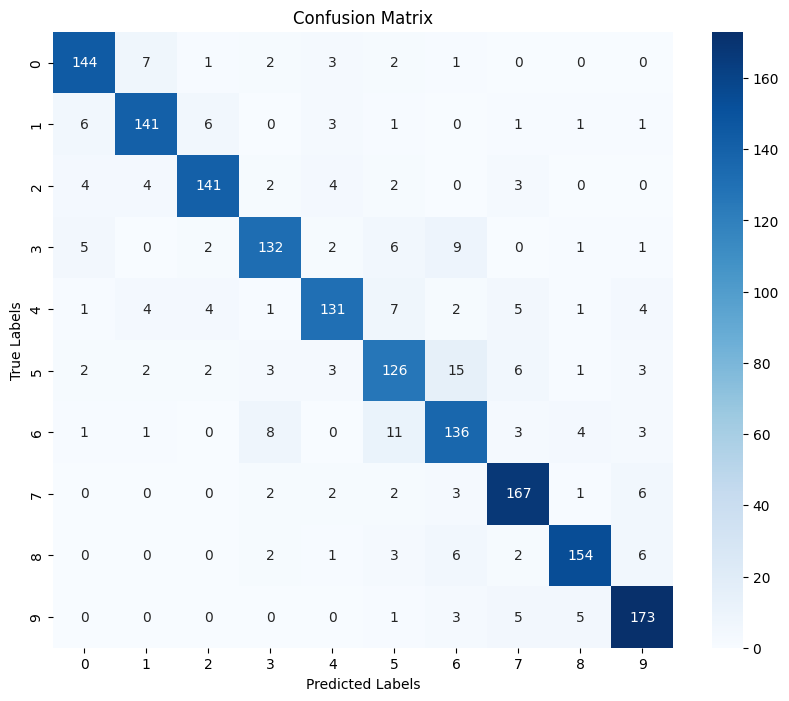

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


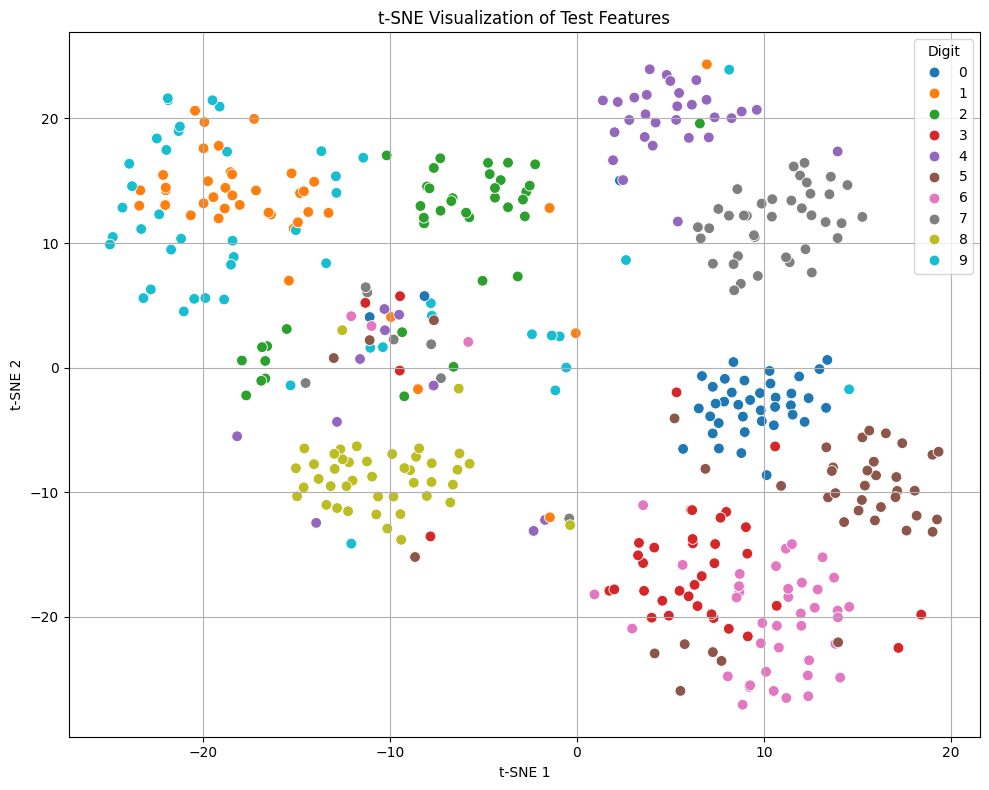

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE on training or validation feature space
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_test_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test, palette='tab10', legend='full', s=60)
plt.title("t-SNE Visualization of Test Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Digit")
plt.grid(True)
plt.tight_layout()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


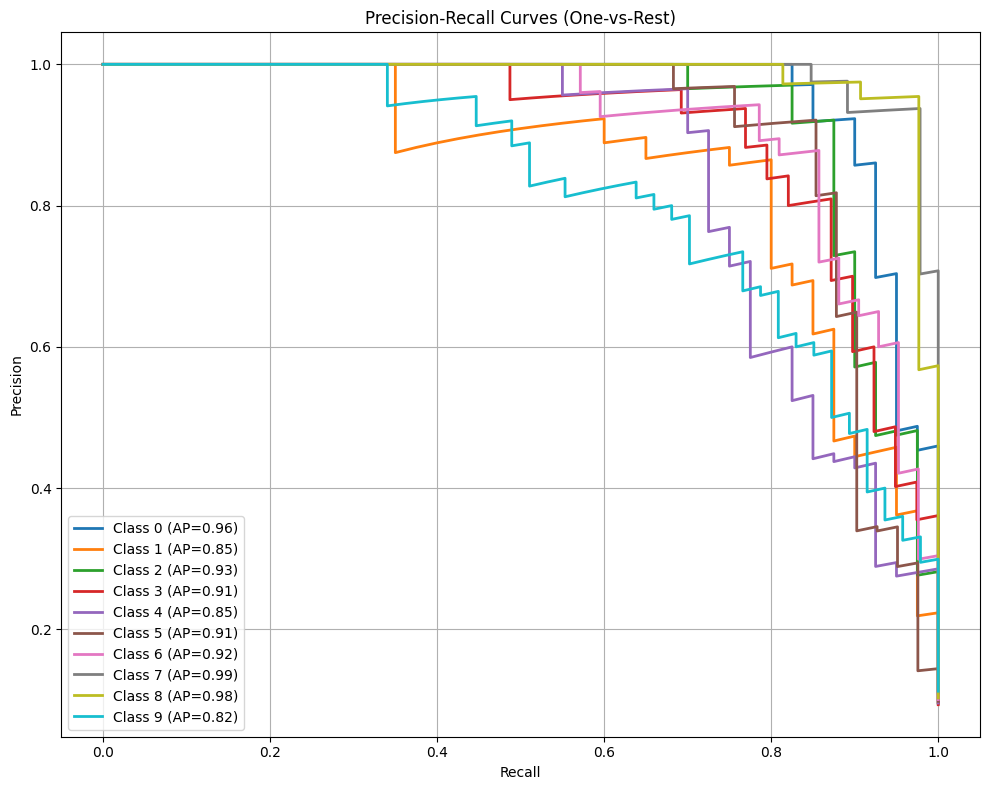

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get true labels and predicted probabilities
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # shape: (n_samples, n_classes)
y_scores = model.predict(X_test_combined)  # shape: (n_samples, n_classes)

# Compute PR curves
plt.figure(figsize=(10, 8))
for i in range(10):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (AP={ap_score:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


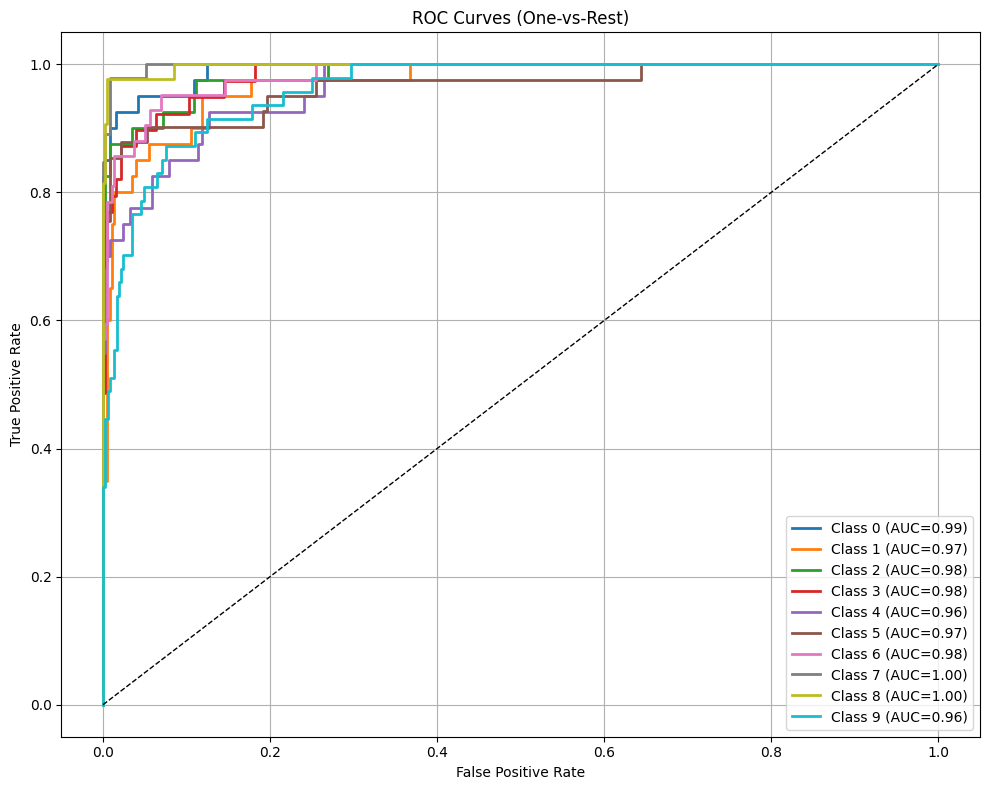

In [31]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
